#### This example follows a logic for big data samplinig of the standard post analysis

Data presented here, as new inputs for this jupyter-notebook, comes from the written-shell pipeline created to extract X-ray excited-state features from some specific pair of atoms group (e.g. pair amino acid). Outputs here are filtered features that account for specific transitions (coreMO -> virtualMO) for the specific pair of atoms group

##### Check out the paper of this work <br>
#### *X-ray absorption spectroscopy reveals charge transfer in π-stacked aromatic amino acids*:<br> https://doi.org/10.1039/D4CP04615C

### Read and use this document to calculate the electron transition density atomic contribution matrix
$$
\huge \tilde{\gamma}^{[l,m]}_{AA^{\prime}}
$$

In [1]:
import numpy as np
import pandas as pd
import csv as csv

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns

In [55]:
import h5py

____________________________

#### General case of the post analysis for a list of molecules

The required data are the standard csv files obtained from the https://github.com/caraortizmah/x-ray_scripting_out pipeline which encodes the required information for the calculation of the electronic transition density atomic contribution matrix.

#### Before starting, create a list file (for the csv files) with two columns (hash, file) listing all the csv files by property/component.
For instance the case of *resA core MO*:


Create a file named `resA_MOcore_list.log` where the first column is a list with a hash, e.g., f01, f02, ...f99 and
the second is the name of the csv file to explore (in this case only the resA MO core csv files).

The file should look like:
>  f00,(path)../newFY_1-26/resA_MOcore_AB_2.5A_1-26.csv <br>
>  f01,(path)../newFY_1-26/resA_MOcore_AB_2.6A_1-26.csv <br>
>  f02,(path)../newFY_1-26/resA_MOcore_AB_2.7A_1-26.csv <br>
>  f03,(path)../newFY_1-26/resA_MOcore_AB_2.8A_1-26.csv <br>
>  ... <br>
>  f61,(path)../newFY_1-26/resA_MOcore_AB_11.0A_1-26.csv <br>

______________________________________

#### Functions for processing data
______________________________________________

In [3]:
def load_dict_data(filename, index_col_condition='num-1'):
    """
    Reads from a two-column file the hash and the file and
     stores the information of the csv file into a dictionary.
    Format file to be read:
     f00,(path)../newFY_1-26/resA_MOcore_AB_2.5A_1-26.csv
     f01,(path)../newFY_1-26/resA_MOcore_AB_2.6A_1-26.csv
     f02,(path)../newFY_1-26/resA_MOcore_AB_2.7A_1-26.csv
     f03,(path)../newFY_1-26/resA_MOcore_AB_2.8A_1-26.csv
      ...
     f61,(path)../newFY_1-26/resA_MOcore_AB_11.0A_1-26.csv 
    Args:
     filename (str): two-column file filename having
      a hash for each path file.
     index_col_condition (str): the name of the index 
      column to read the csv as pandas structure.
      Default as 'num-1'
    Output (dict): keys are the hashes and values of the dictionary
     are the pandas frame for each csv file.
    """
    # Initialize a dictionary
    dict_raw = {}
    # Open the list file
    with open(filename, 'r') as file:
        # Read each line in the file
        for line in file:
            line = line.strip()
    # {(key) hash = line.split(',')[0] : (value) file_n = line.split(',')[1]}
            dict_raw.update({
                line.split(',')[0]: # key
                pd.read_csv(line.split(',')[1],
                            delimiter=',',
                            index_col=index_col_condition) # value
            })
    return dict_raw

In [57]:
def save_ETDAC_matrix(data_dict, data_set_name="data_etdac_matrix.h5"):
    """
    Get the node/edge features for each molecule and save
    all the results in H5PY format.
    Args:
    data_dict (dict) contains a hash (key) and 
     the ETDAC matrix (value) of each molecule.
    data_set_name (str, optional) is the name of the H5PY file to be
     created. By default that file is called "data_etdac_matrix.h5".
    """
    
    with h5py.File(data_set_name, 'w') as f:

        # Get node/edge features for the list of molecules
        for hash in data_dict.keys():
#df.to_hdf('data.h5', key='df', mode='w', format='table')
            qm_group = f.create_group(f"sample_{hash}")
            qm_group.create_dataset("ETDAC_matrix", data=data_dict[hash], compression="gzip")
            
            qm_group.attrs["hash"] = hash

#### Functions for the algebra operations

In [4]:
def selecting_atm_matrix(df, atoms_list):
    """
    it returns MO matrix (df) having just the atoms in atoms_list.
    """
    col_list = df.index.tolist() #listing index (elements from column 0)
    #dff = df.loc[:, (df != 0).any(axis=0)] #removing zero columns
    return df.loc[[i for i in atoms_list if i in col_list]] #returning just columns in the both lists intersection
#atoms_core=resa_mocore_GFG9Y_raw.index.tolist() #all C-core atoms
#[i for i in atoms_a if i in atoms_core] #atoms_a intersection atoms_core

In [5]:
def crop_by_loewdin_p(df,pop):
    """
    it returns MO matrix (df) having just a Loewdin MO population contribution greater than (100*pop)%.
    pop is a number between 0 and 1.
    """
    #cols = [col for col, val in df.sum()[2:].iteritems() if val > (pop*100)]
    cols = [col for col, val in df.sum()[2:].items() if val > (pop*100)]
    #iteritem() create a zip with the index_col and the values
    cols.insert(0,'lvl')
    cols.insert(0,'sym')
    #to add on the top the first two columns removed in the previous sum() evaluation
    return df[cols] #showing the fisrt two columns and those having population greater than pop*100%

In [6]:
def nonzero_mo_matrix(df):
    """
    it returns MO matrix (df) having just non-zero MO population.
    """
    return df.loc[:, (df != 0).any(axis=0)] #removing zero columns

In [7]:
def cropping_matrix(df, df1, df2):
    """
    it returns a cropped MO matrix from df using as parameters the indices in df1 and df2.
    df1 index are column names from df and df2 index are the rows from df
    """
    try:
        dff = df[df1.axes[1][2:].tolist()] #saving specific columns
    except KeyError:
        tmp_mo = [item for item in df1.axes[1][2:].tolist() if item in df.axes[1][0:].tolist()]
        #removing items in the first list that are not in the second one
        dff = df[tmp_mo]
    try:
        return dff.loc[[int(i) for i in df2.axes[1][2:].tolist()]] #returning specific rows
    except KeyError:
        tmp_mo2 = [item for item in df2.axes[1][2:].tolist() if int(item) in dff.T.axes[1][0:].tolist()]
        # dff.T to obtain the index_col as the head row
        return dff.loc[[int(i) for i in tmp_mo2]] #returning specific rows
# the first two elements in df2.axes[1] and df1.axes[1] are "sym" and "lvl", that's why I used df.axes[1][2:]

In [8]:
def remove_noncontrb(dict_data_raw):
    """
    Drops off the non-contributing elements to avoid
    zero or nan spread on the following linear algebra 
    operations.
    This function depends on the nonzero_mo_matrix()
     to work.
    Args:
    dict_data_raw (dict): the pd.frames inside can have zeroes
     or nan values.
    Output (dict): dict_data only with nonzero elements.
    """
    dict_data = {}
    for key, value in dict_data_raw.items():
        dict_data.update({key: nonzero_mo_matrix(value)})
    return dict_data

#### Main functions: ETDAC matrix calculation

##### Building heatmaps of $\tilde{\gamma}^{[l,m]}_{AA^{\prime}}$

In [9]:
def ts_psb_acore_bvirt(acore, bvirt, abcorevirt, atm_to_virtmo=False):
    """
    Do a matrix multiplication between the core-to-virt transition 
    probabilities matrix and the core MO matrix, then the resulting matrix
    is multiplied by the virtual MO matrix.
    if atm_to_virtmo is True, then the two resulting matrices in the 
    multiplication process are returned.
    By the default, just the last matrix is returned.
    """
    abcorevirt.index = abcorevirt.index.astype('str') 
    #to make possible the dot product in pandas, the indexes involved in each
    #product have to "match" in name and type
    
    i = j = 0
    dff = pd.DataFrame(np.zeros((acore.shape[0], abcorevirt.shape[0])), \
                       index=acore.index, columns=abcorevirt.index)
    for j in range(abcorevirt.shape[1]):
        for i in range(acore.shape[1]):
            try:
                dff += acore.T[i:i+1].T.dot(abcorevirt.iloc[:].T[j:j+1])
            except:
                pass
            
    dff = dff/100
    i = j = 0
    dff2 = pd.DataFrame(np.zeros((dff.shape[0], bvirt.shape[0])), \
                        index=dff.index, columns=bvirt.index)
    for i in range(dff.shape[1]):
        for j in range(bvirt.shape[1]):
            try:
                dff2 += dff.T[i:i+1].T.dot(bvirt.T[j:j+1])
            except:
                pass
    
    if atm_to_virtmo:
        return dff, dff2
    else:
        return dff2

In [10]:
def heatmap_ETDAC(core_MO, virt_MO, fosce_mo_trans):
    """
    Runs the ts_psb_acore_bvirt() function to calculate the
     electron transition density atomic contribution matrix 
     by performing some matrix transformations in the 
     core_MO and virt_MO pd.frames that are stored as
     values in dictionary.
    Args:
    core_MO (dict): core MO and atom population matrices 
     obtained by load_dict_data() and remove_noncontrb()
    virt_MO (dict): virtual MO and atom population matrices 
     obtained by load_dict_data()
    fosce_mo_trans (dict): electronic transition
     (oscillator strength) MO matrices obtained by the pipeline
     (github.com/caraortizmah/x-ray_scripting_out) and 
     formated by load_dict_data()
    Output:
    heatmap_raw (dict): The electron transition density 
     atomic contribution (ETDAC) matrix in pd.frame format.
    """
    # WSM case
    # Exploiting the fact that all data share same order of the keys (hashes)
    heatmap_raw = {}
    for key in virt_MO.keys(): 
        # it can be any of the created dictionaries, they have same keys and in the same order
        heatmap_raw.update({
            key:
            ts_psb_acore_bvirt(
                core_MO[key].T[2:].T,
                virt_MO[key].T[2:].T,
                fosce_mo_trans[key])
        })
    return heatmap_raw

In [11]:
def crop_heatmap_byatm(etdac_m, row_cond, col_cond):
    """
    Crop the electron transition density atomic 
     contribution matrix by using a range of atoms
     that are in the core space and in the virtual
     space.
    Args:
    etdac_m (pd.frame): Electron transition density atomic 
     contribution matrix.
    row_cond (lambda): if-statement using the range of 
     atoms of the core space.
    col_cond (lambda): if-statement using the range of
     atoms of the virtual space.
    Outputs:
     etdac_m cropped by using two lambda functions.
    """
    return etdac_m.loc[
    [i for i in etdac_m.index.values if row_cond(i)],
    [i for i in etdac_m.columns.values if col_cond(i)]
    ]

______________________________________________

Data in .csv format
##### residue called as A is that one expressed in the core space
> ##### resA core MO
$$
\LARGE \boldsymbol{\text{N}}_{A,i}
$$
##### residue called as B is that one expressed in the virtual space
> ##### resB virtual MO
$$
\LARGE \boldsymbol{\text{N}}_{A^{\prime},a}
$$
In a pair-aa interaction, e.g. Phe-Tyr, Phenylalanine stands for resA core MO and Tyrosine for resB virtual MO

> ##### resA core MO - Phenylalanine

In [12]:
resa_mocore_raw = load_dict_data('resA_MOcore_list.log', 'num-1')

> ##### resB virt MO - Tyrosine

In [13]:
resb_movirt_raw = load_dict_data('resB_MOvirt_list.log', 'num-1')

##### coreMO vs. virtual MO (core/virt MO)
##### example resA(Phe) --> resB(Tyr)

> ### 1. core/virt MO as function of the number of transitions

#### Repeat the hashing and listing csv files procedure (as done above) for each property/component

In [14]:
corevirtMO_raw = load_dict_data('corevirtMO_list.log', 'virt\core')

> ### 2. core/virt MO as function of the number of transitions averaged probability
$$
\LARGE \rho^{n}_{ia}
$$

#### Repeat the hashing and listing csv files procedure for each property/component

In [15]:
corevirtMO_tspb_raw = load_dict_data('corevirtMO_tspb_list.log', 'virt\core')

> ### 3. core/virt MO as function of the oscillator strength using electronic dipole moment as operator
> #### by weighted (WSM): fosce, sum and weighted average (WAM): foscwe
$$
\LARGE \gamma^{[l,m]}_{ia}
$$

#### Repeat the hashing and listing csv files procedure for each property/component

In [16]:
corevirtMO_fosce_raw = load_dict_data('corevirt_fosce_AB_list.log', 'virt\core')

Repeat the hashing and listing csv files procedure for each property/component

In [17]:
#corevirtMO_foscwe_raw = load_dict_data('corevirt_foscwe_AB_list.log', 'virt\core')

<html>


<body>
<h3 id="title">Reducing Löwdin Population MO matrices by removing non-contributing MO</h3>
<h4> Case for core MO in the resA</h4>
</body>
</html>

In [18]:
resa_mocore = remove_noncontrb(resa_mocore_raw)

<html>

<body>
<h4> Case for virtual MO in the resB</h4>
</body>
</html>
<html>

In [19]:
resb_movirt = remove_noncontrb(resb_movirt_raw)

___________________________

### Results

_________________________________________________

## Final calculation
$$
\huge \tilde{\gamma}^{[l,m]}_{AA^{\prime}}
$$

WSM case, it is the official representation by the domain-knowledge

In [20]:
heatmap_raw = heatmap_ETDAC(resa_mocore, resb_movirt_raw, corevirtMO_fosce_raw)

WAM case is no longer used, it is presented but all the work was performed using the WSM case.
However is important to highlight that WAM and WSM act as representations, so it is the domain-knowledge of the user who decides.

In [21]:
for key in heatmap_raw.keys():
    heatmap_raw[key].index.names = ['core-atom']
    heatmap_raw[key].columns.names = ['virtual-atom']

In [22]:
heatmap = {}
for key in heatmap_raw.keys():
    heatmap.update({
        key:
        heatmap_raw[key].apply(pd.to_numeric).sort_index(ascending=True)
    })

#### Saving data

In [58]:
save_ETDAC_matrix(heatmap, data_set_name="data_etdac_matrix.h5")

In [23]:
## test purposes
rel_list = []
tmp_keys = [key for key in heatmap.keys()][10:58] #from 3.5 to 9.0 A
for ii in tmp_keys: 
    rel_list.append(heatmap[ii].max().max())
relmax = max(rel_list)
relmin = min(rel_list)
relmin, relmax

(0.5440394435611963, 1.1369871456805003)

##### Plot electron transition density atomic contribution (ETDAC) matrices

<Axes: xlabel='virtual-atom', ylabel='core-atom'>

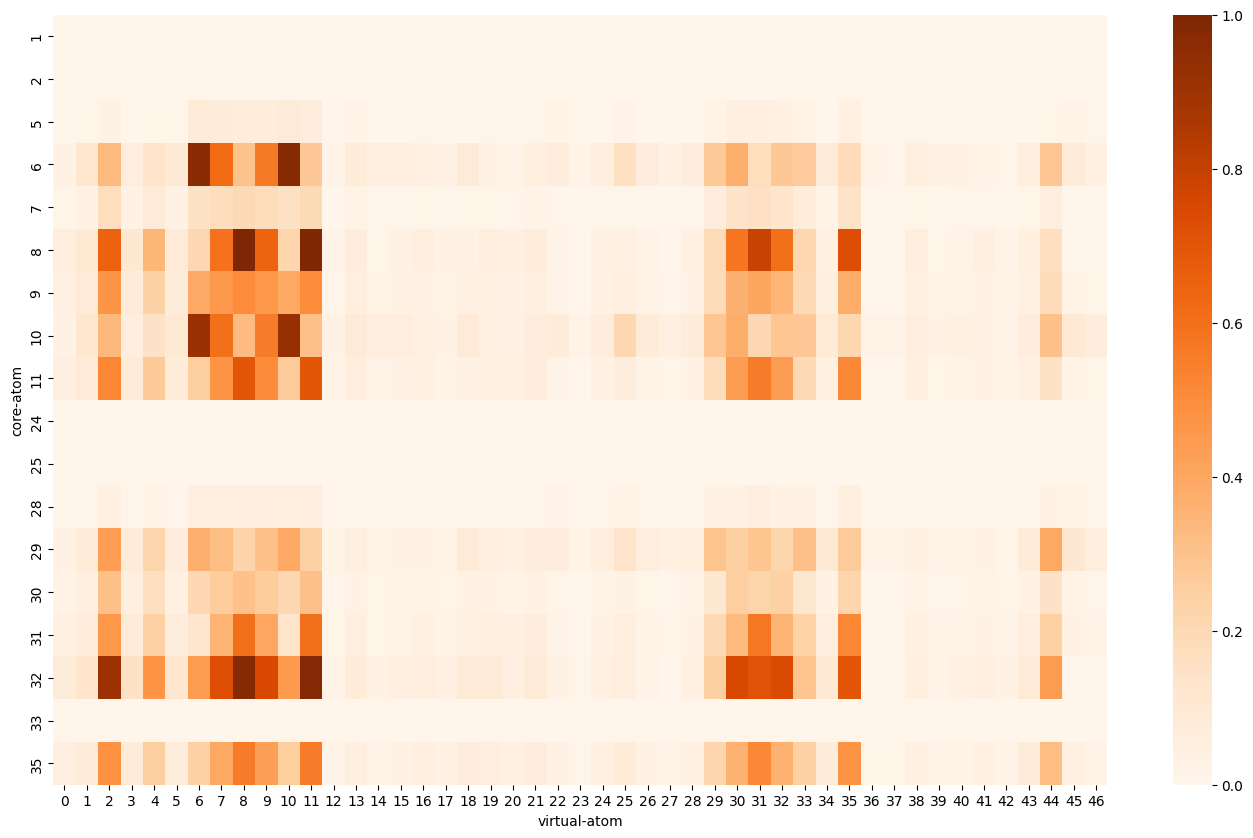

In [24]:
fig, ax = plt.subplots(figsize=(17,10)) 
test = (heatmap['f13'] - heatmap['f13'].min().min())/(heatmap['f13'].max().max() - heatmap['f13'].min().min())
sns.heatmap(test, annot=False, cmap='Oranges', vmin=0, vmax=1, ax=ax)

#### Definition of amino acids using range of atoms
##### Example is the same Phe --- Tyr

##### Set atoms

In [25]:
atomAi = 0
atomAf = 22
atomBi = 23
atomBf = 46

In [26]:
atomAi, atomAf, atomBi, atomBf

(0, 22, 23, 46)

#### Delitimation of atoms of the aromatic rings

In [27]:
atomFi = 6
atomFf = 11
atomYi = 29
atomYf = 33
atomYf2 = 35

#### Calculating the 4 (more) terms of the transition intensities

In [28]:
inter_fosce = []
all_fosce = []
FYpi_inter_fosce = []
YFpi_inter_fosce = []
aropi_inter_fosce = []
keys = []

for key in heatmap.keys():
    keys.append(key)
    row_cond_1, col_cond_1 = lambda i: i > atomAf, lambda i: i < atomBi
    row_cond_2, col_cond_2 = lambda i: i <= atomAf, lambda i: i >= atomBi
    inter_fosce.append(
        crop_heatmap_byatm(heatmap[key], row_cond_1, col_cond_1).sum().sum() +
        crop_heatmap_byatm(heatmap[key], row_cond_2, col_cond_2).sum().sum()
    )
    row_cond_1 = lambda i: i >= atomFi and i <= atomFf
    col_cond_1 = lambda i: (i >= atomYi and i <= atomYf) or i == atomYf2
    FYpi_inter_fosce.append(
        crop_heatmap_byatm(heatmap[key], row_cond_1, col_cond_1).sum().sum()
        )
    row_cond_1 = lambda i: (i >= atomYi and i <= atomYf) or i == atomYf2
    col_cond_1 = lambda i: i >= atomFi and i <= atomFf
    YFpi_inter_fosce.append(
        crop_heatmap_byatm(heatmap[key], row_cond_1, col_cond_1).sum().sum()
        )
    
    aropi_inter_fosce = [FYpi_inter_fosce[i] + YFpi_inter_fosce[i] for i in range(len(inter_fosce))]
    
    all_fosce.append(heatmap[key].sum().sum())
    
intra_fosce = [all_fosce[i] - inter_fosce[i] for i in range(len(inter_fosce))]

In [29]:
max(inter_fosce), max(intra_fosce), max(all_fosce)

(22.147341668207414, 46.152039574660364, 48.707449072901845)

In [30]:
dfftotal_fosce = pd.DataFrame({'hash': [i for i in keys],\
                               'inter_fosce': [i for i in inter_fosce],\
                               'intra_fosce': [i for i in intra_fosce],\
                               'all_fosce': [i for i in all_fosce],\
                               'FY_pi':[i/max(inter_fosce) for i in FYpi_inter_fosce],\
                               'YF_pi':[i/max(inter_fosce) for i in YFpi_inter_fosce],\
                               'pi_pi':[i/max(inter_fosce) for i in aropi_inter_fosce],\
                               'abs_pi_pi':[i for i in aropi_inter_fosce]
                              })

In [31]:
dfftotal_fosce

,hash,inter_fosce,intra_fosce,all_fosce,FY_pi,YF_pi,pi_pi,abs_pi_pi
0,f00,15.811635,16.028700,31.840335,0.318738,2.856156e-01,6.043538e-01,13.384830
1,f01,16.097037,16.488014,32.585051,0.329830,2.809608e-01,6.107911e-01,13.527399
2,f02,16.346659,16.933081,33.279740,0.325315,2.782393e-01,6.035543e-01,13.367123
3,f03,16.115904,17.727001,33.842905,0.392324,2.040862e-01,5.964098e-01,13.208891
4,f04,17.825560,18.625099,36.450659,0.314734,3.209828e-01,6.357171e-01,14.079444
...,...,...,...,...,...,...,...,...
57,f57,0.004151,46.036660,46.040810,0.000000,1.216044e-04,1.216044e-04,0.002693
58,f58,0.000004,46.121536,46.121541,0.000000,1.303174e-07,1.303174e-07,0.000003
59,f59,0.000002,46.140848,46.140851,0.000000,6.659987e-08,6.659987e-08,0.000001
60,f60,0.000000,46.050159,46.050159,0.000000,0.000000e+00,0.000000e+00,0.000000


#### Data to be saved

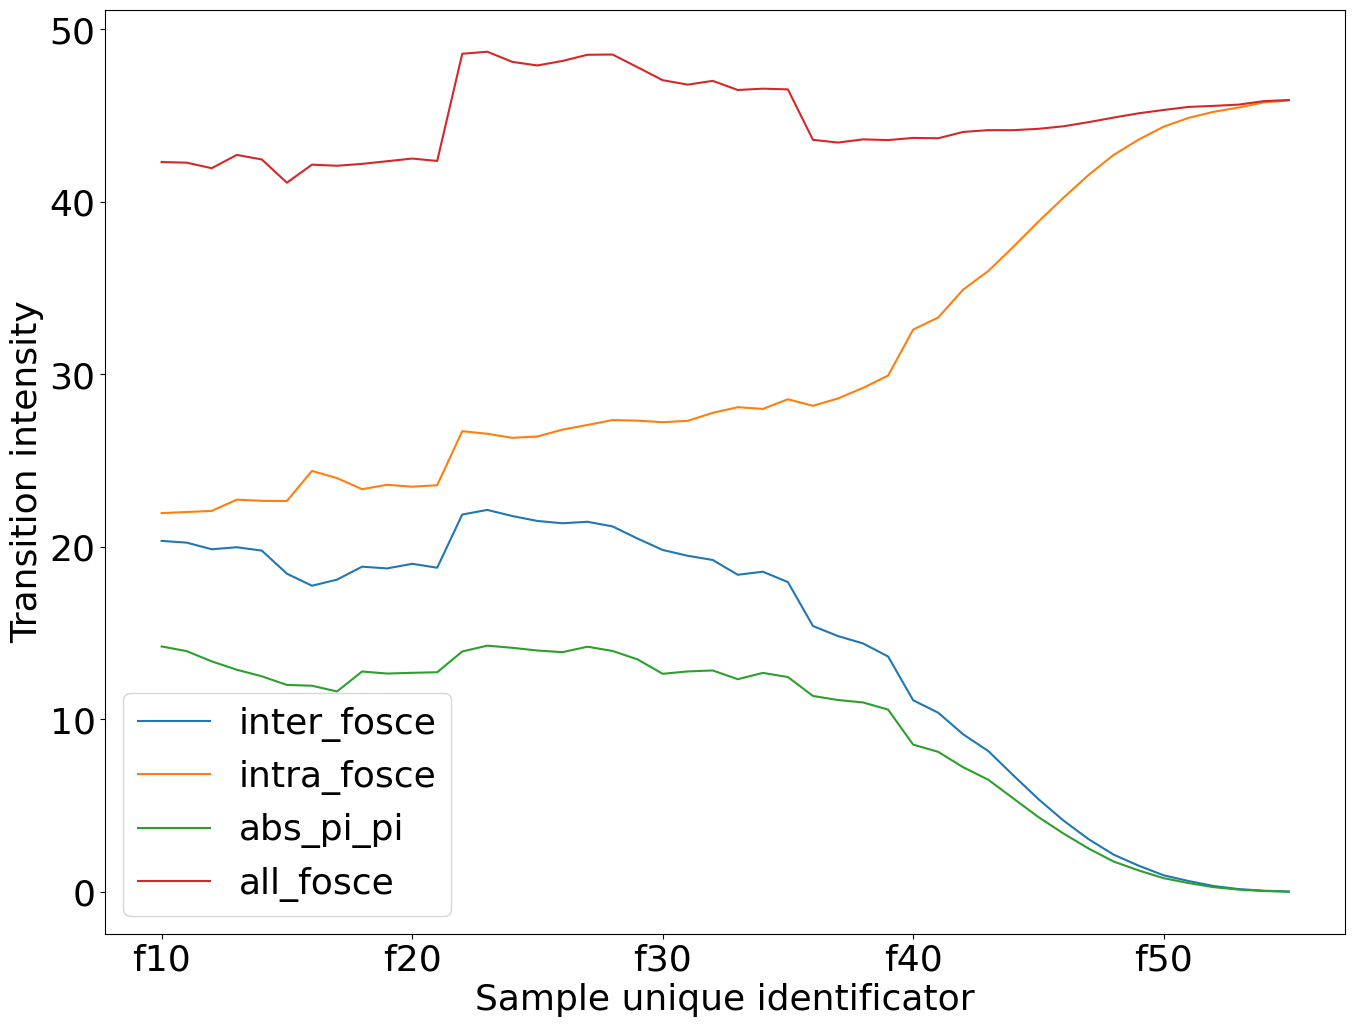

In [32]:
plt.rc('font', size=26)
ax = dfftotal_fosce.loc[10:55,:].plot(
    x="hash",
    y=["inter_fosce","intra_fosce","abs_pi_pi", "all_fosce"],
    kind="line",
    figsize=(16, 12))
ax.set_xlabel('Sample unique identificator')
ax.set_ylabel('Transition intensity')

plt.show()

#### That's it :)